<a href="https://colab.research.google.com/github/Sounak97/Assignment-5/blob/Sounak97/validation_set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Validation
Learning Objectives:

Use multiple features, instead of a single feature, to further improve the effectiveness of a model
Debug issues in model input data
Use a test data set to check if a model is overfitting the validation data
As in the prior exercises, we're working with the California housing data set, to try and predict median_house_value at the city block level from 1990 census data.



SETUP
First off, let's load up and prepare our data. This time, we're going to work with multiple features, so we'll modularize the logic for preprocessing the features a bit:

In [70]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")
california_housing_dataframe = california_housing_dataframe.reindex(
     np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
10670,-120.6,39.8,15.0,1291.0,283.0,582.0,242.0,2.1,102000.0
2429,-117.6,33.7,4.0,3305.0,644.0,1693.0,597.0,5.2,215000.0
12845,-121.8,38.0,25.0,3018.0,606.0,1614.0,568.0,3.5,127000.0
7795,-118.4,34.1,19.0,5076.0,1034.0,2021.0,960.0,5.6,309200.0
8295,-118.5,34.0,23.0,3771.0,1321.0,2031.0,1241.0,2.8,277500.0
...,...,...,...,...,...,...,...,...,...
799,-117.1,33.1,17.0,1893.0,297.0,936.0,287.0,5.2,157700.0
6050,-118.2,34.0,32.0,2232.0,603.0,2361.0,608.0,2.6,170900.0
6976,-118.3,34.0,47.0,1525.0,359.0,982.0,333.0,2.1,126600.0
5766,-118.2,33.9,40.0,1334.0,276.0,1226.0,278.0,3.5,144300.0


In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features
def preprocess_targets(california_housing_dataframe):
    """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
    output_targets=pd.DataFrame()
    #scaling the target
    output_targets['median_house_value']=(california_housing_dataframe['median_house_value']/1000.0)
    return output_targets

In [72]:
#choosing the training set as first 12000 of 17000 rows,keeping a conventional ratio
training_examples=preprocess_features(california_housing_dataframe.head(12000))
training_examples.describe()


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2641.8,538.9,1425.2,500.5,3.9,2.0
std,2.1,2.0,12.6,2165.2,416.7,1129.9,379.1,1.9,1.1
min,32.5,-124.3,1.0,8.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1465.0,297.0,791.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2135.5,437.0,1171.0,412.0,3.5,1.9
75%,37.7,-118.0,37.0,3152.2,651.0,1718.2,606.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,5471.0,35682.0,5189.0,15.0,52.0


In [73]:
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
training_targets.describe()

,median_house_value
count,12000.0
mean,207.2
std,116.1
min,15.0
25%,119.1
50%,180.1
75%,265.6
max,500.0


In [74]:
#Now taking the validation set as the remaining 5000 rows,test set will constitute of never-before-seeen data
validation_examples=preprocess_features(california_housing_dataframe.tail(5000))
validation_examples.describe()


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.5,2648.1,540.7,1440.1,503.0,3.9,2.0
std,2.1,2.0,12.6,2215.1,432.7,1189.8,397.4,1.9,1.3
min,32.5,-124.3,2.0,2.0,2.0,6.0,2.0,0.5,0.1
25%,33.9,-121.8,18.0,1447.8,295.0,786.8,279.0,2.6,1.5
50%,34.2,-118.5,29.0,2106.5,428.0,1157.0,402.0,3.5,1.9
75%,37.7,-118.0,37.0,3149.5,644.2,1726.0,604.2,4.7,2.3
max,41.9,-114.6,52.0,32627.0,6445.0,28566.0,6082.0,15.0,55.2


In [75]:
validation_targets=preprocess_targets(california_housing_dataframe.tail(5000))
validation_targets.describe()

,median_house_value
count,5000.0
mean,207.6
std,115.8
min,15.0
25%,120.8
50%,180.6
75%,263.4
max,500.0


TASK 1:Examining the data

In [76]:
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
10670,-120.6,39.8,15.0,1291.0,283.0,582.0,242.0,2.1,102000.0
2429,-117.6,33.7,4.0,3305.0,644.0,1693.0,597.0,5.2,215000.0
12845,-121.8,38.0,25.0,3018.0,606.0,1614.0,568.0,3.5,127000.0
7795,-118.4,34.1,19.0,5076.0,1034.0,2021.0,960.0,5.6,309200.0
8295,-118.5,34.0,23.0,3771.0,1321.0,2031.0,1241.0,2.8,277500.0
...,...,...,...,...,...,...,...,...,...
799,-117.1,33.1,17.0,1893.0,297.0,936.0,287.0,5.2,157700.0
6050,-118.2,34.0,32.0,2232.0,603.0,2361.0,608.0,2.6,170900.0
6976,-118.3,34.0,47.0,1525.0,359.0,982.0,333.0,2.1,126600.0
5766,-118.2,33.9,40.0,1334.0,276.0,1226.0,278.0,3.5,144300.0


In [0]:
#fluctuations in meadian_age,suddnen jumps to over 50
#maximum median house value is 500,000 which seems lie it has been tampered with
#california_housing_dataframe['rooms_per_person']=(california_housing_dataframe['total_rooms']/california_housing_dataframe['population'])

In [0]:
#california_housing_dataframe.describe()

In [0]:
#in pone of the cases the room_per_person is over 55 which is indicative of corruptability


TASK 2: Plot Latitude/Longitude vs. Median House Value
Let's take a close look at two features in particular: latitude and longitude. These are geographical coordinates of the city block in question.

This might make a nice visualization — let's plot latitude and longitude, and use color to show the median_house_value.**bold text**

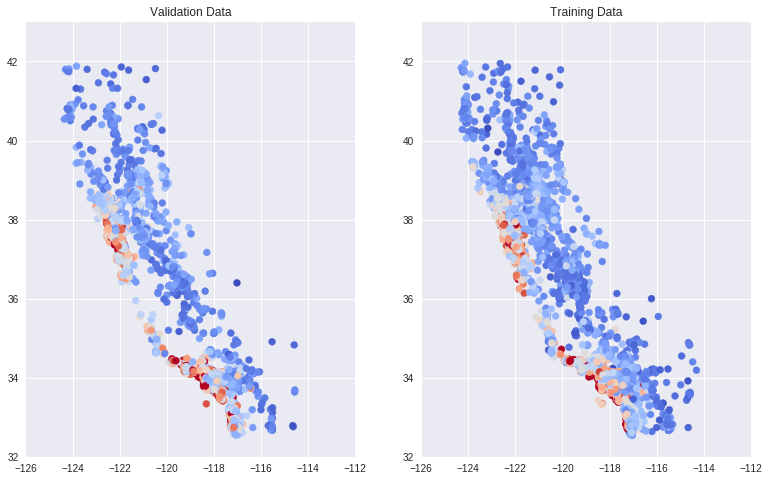

In [79]:
plt.figure(figsize=(13, 8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Validation Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(validation_examples["longitude"],
            validation_examples["latitude"],
            cmap="coolwarm",
            c=validation_targets["median_house_value"] / validation_targets["median_house_value"].max())

ax = plt.subplot(1,2,2)
ax.set_title("Training Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(training_examples["longitude"],
            training_examples["latitude"],
            cmap="coolwarm",
            c=training_targets["median_house_value"] / training_targets["median_house_value"].max())
_ = plt.plot()

In [0]:
#value splitting has not been uniform for the training and the validation sets

TASK 3: Returning to the Data Importing and Pre-Processing Code

In [0]:
#randomizing the data
#provides a much better output in the validation set


TASK 4: Train and Evaluate a Model
The previous TensorFlow model is reused

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of multiple features.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
#Because we're now working with multiple input features, let's modularize our code for configuring feature columns into a separate function. (For now, this code is fairly simple, as all our features are numeric, but we'll build on this code as we use other types of features in future exercises.)

In [0]:
def construct_feature_columns(input_features):
  return set([tf.feature_column.numeric_column(my_feature)
             for my_feature in input_features])
   

In [0]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model of multiple features.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # 1. Create input functions.
  training_input_fn = lambda:my_input_fn(training_examples,training_targets['median_house_value'],batch_size=batch_size)
  predict_training_input_fn = lambda:my_input_fn(training_examples,training_targets['median_house_value'],num_epochs=1,shuffle=False)
  predict_validation_input_fn = lambda:my_input_fn(validation_examples,validation_targets['median_house_value'],num_epochs=1,shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # 2. Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

inspirations from the previous model is taken bu this time we are interested in multiple features

Training model...
RMSE (on training data):
  period 00 : 217.48
  period 01 : 199.78
  period 02 : 186.91
  period 03 : 177.34
  period 04 : 170.86
  period 05 : 167.39
  period 06 : 166.07
  period 07 : 166.53
  period 08 : 167.45
  period 09 : 168.84
Model training finished.


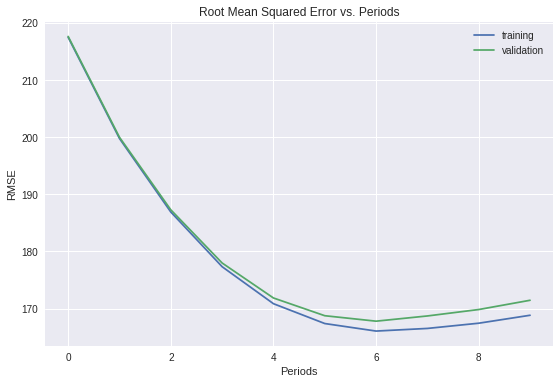

In [86]:
linear_regressor=train_model(learning_rate=0.00003,steps=500,batch_size=5,training_examples=training_examples,training_targets=training_targets,validation_examples=validation_examples,
    validation_targets=validation_targets)

TASK 5: Evaluate on Test Data

In [90]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")
test_examples=preprocess_features(california_housing_test_data)
test_targets=preprocess_targets(california_housing_test_data)
predict_test_input_fn=lambda:my_input_fn(
   test_examples,test_targets['median_house_value'],num_epochs=1,shuffle=False
)
test_predictions=linear_regressor.predict(input_fn=predict_test_input_fn)
test_predictions=np.array([item['predictions'][0] for item in test_predictions])
root_mean_squared_error=math.sqrt(metrics.mean_squared_error(test_predictions,test_targets))
print("Final RMSE on test data = %0.2f", root_mean_squared_error)


Final RMSE on test data = %0.2f 162.8121723978867
